In [58]:
import pandas as pd
import pickle
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [ ]:

def hist_vext_raw(data, cutoff, bins=100, log_bins=False):
    data = jnp.array(data)
    data = data[data < cutoff].flatten()

    if log_bins:
        bins = np.logspace(np.log10(data.min()), np.log10(data.max()), bins)

    hist, bin_edges = np.histogram(data, bins=bins)
    return hist, bin_edges

def hist_vext_exp(data, cutoff, bins=100, log_bins=True):
    data = jnp.array(data)
    data = data[data < cutoff].flatten()
    data_exp = jnp.exp(-data)

    if log_bins:
        bins = np.logspace(np.log10(data_exp.min()), np.log10(data_exp.max()), bins)

    hist, bin_edges = np.histogram(data_exp, bins=bins)
    return hist, bin_edges


# ---- TESTS ----
def test_hist_vext_raw():
    test_data = jnp.array([0, 1, 2, 3, 10])   # 10 ist über cutoff
    hist, bins = hist_vext_raw(test_data, cutoff=5, bins=5, log_bins=False)

    # Erwartung: nur 0,1,2,3 dürfen drin sein
    assert hist.sum() == 4, f"Erwartet 4 Werte, aber {hist.sum()} gefunden"
    assert all(bins[:-1] < 5), "Bins enthalten Werte größer als cutoff"
    print("✅ test_hist_vext_raw bestanden")

def test_hist_vext_exp():
    test_data = jnp.array([0, 1, 2, 3, 10])
    hist, bins = hist_vext_exp(test_data, cutoff=5, bins=5, log_bins=True)

    # exp(-x) für 0,1,2,3 = [1.0, 0.3679, 0.1353, 0.0498]
    values = np.exp(-np.array([0,1,2,3]))
    assert hist.sum() == len(values), f"Erwartet {len(values)} Werte, aber {hist.sum()} gefunden"
    assert np.all(values <= bins.max()), "exp-Werte liegen außerhalb der Bins"
    print("✅ test_hist_vext_exp bestanden")

# ---- Ausführen ----
if __name__ == "__main__":
    test_hist_vext_raw()
    test_hist_vext_exp()

# (Optional, nur im Notebook)
# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# <-- hier stehen DEINE Funktionen hist_vext_raw / hist_vext_exp schon im Namespace -->

def plot_from_hist(hist, bin_edges, ax=None, xlog=False, title=""):
    """
    Plottet ein Histogramm aus (hist, bin_edges),
    ohne die Daten erneut zu binned.
    """
    if ax is None:
        ax = plt.gca()
    # Balkenbreiten & -positionen aus Kanten ableiten
    widths = bin_edges[1:] - bin_edges[:-1]
    ax.bar(bin_edges[:-1], hist, width=widths, align='edge', edgecolor='black')
    if xlog:
        ax.set_xscale("log")
    ax.set_title(title)
    ax.set_xlabel("Wert")
    ax.set_ylabel("Häufigkeit")
    return ax

# ---- Test mit deinen Funktionen ----
def test_plots_with_functions(data, cutoff=5, bins=100):
    # Nutze exakt deine Funktionen
    hist_raw, bins_raw = hist_vext_raw(data, cutoff=cutoff, bins=bins, log_bins=False)
    hist_exp, bins_exp = hist_vext_exp(data, cutoff=cutoff, bins=bins, log_bins=True)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_from_hist(hist_raw, bins_raw, ax=axes[0], xlog=False, title=f"Rohdaten (cutoff={cutoff})")
    plot_from_hist(hist_exp, bins_exp, ax=axes[1], xlog=True,  title=f"exp(-x) (cutoff={cutoff}, log-bins)")
    plt.tight_layout()
    plt.show()

# Beispielaufruf (data liegt bereits vor)
test_plots_with_functions(data, cutoff=5, bins=100)
test_plots_with_functions(data, cutoff=15, bins=100)



In [ ]:
import os, re, pickle
import numpy as np
import pandas as pd

# --- Einstellungen ---
VEXT_MAX = 15      # cutoff oben
VEXT_MIN = -10    # cutoff unten
N_BINS   = 100

# Logarithmische Kanten im exp(-Vext)-Raum: [e^{-5}, ..., e^{15}]
#EDGES = # Hier sollen die exp(-Vext) äquidistant gebinnt werden

base_dir = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_32grid"
pattern  = re.compile(r"Vext_([A-Z]{3})_(\d+)\.pkl")

all_dfs = []

for temp_folder in os.listdir(base_dir):
    temp_path = os.path.join(base_dir, temp_folder)
    if not (os.path.isdir(temp_path) and temp_folder.startswith("Vext_")):
        continue

    print(f"\n📂 Bearbeite Temperatur-Ordner: {temp_folder}")
    rows = []

    for filename in os.listdir(temp_path):
        if not filename.endswith(".pkl"):
            continue

        m = pattern.match(filename)
        if not m:
            print(f"  ⚠️ Übersprungen (kein gültiger Name): {filename}")
            continue

        struct_name, temp = m.groups()
        file_path = os.path.join(temp_path, filename)

        # Datei laden → numpy-Array
        with open(file_path, "rb") as f:
            data = pickle.load(f)

        arr = np.asarray(data, dtype=np.float64).squeeze()
        arr = arr[np.isfinite(arr)]  # NaN/Inf raus

        # Auf Vext-Bereich [-15, 5] zuschneiden
        if arr.size:
            arr = np.clip(arr, VEXT_MIN, VEXT_MAX)
            arr_exp = np.exp(-arr)  # exp(-Vext)
            hist, _ = np.histogram(arr_exp, bins=EDGES)
        else:
            hist = np.zeros(N_BINS, dtype=int)

        # Zeile bauen
        entry = {"structure": struct_name, "temperature": int(temp)}
        entry.update({f"bin_{i}": int(v) for i, v in enumerate(hist)})
        # optional: Kantenbereich mitschreiben (hilfreich fürs Plotten)
        entry["x_min"] = float(EDGES[0])
        entry["x_max"] = float(EDGES[-1])
        rows.append(entry)

    if rows:
        all_dfs.append(pd.DataFrame(rows))
        print(f"  ✅ {len(rows)} Strukturen verarbeitet")

# Zusammenführen
df_all = pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()
print(f"\n✅ Gesamt-DataFrame mit {len(df_all)} Zeilen erstellt")

df_all.to_csv(os.path.join(base_dir, "Vext_allTEMP_expV_logBin_cut15_-10_100Bins_32grid.csv"), index=False)

SyntaxError: invalid syntax (997517563.py, line 11)

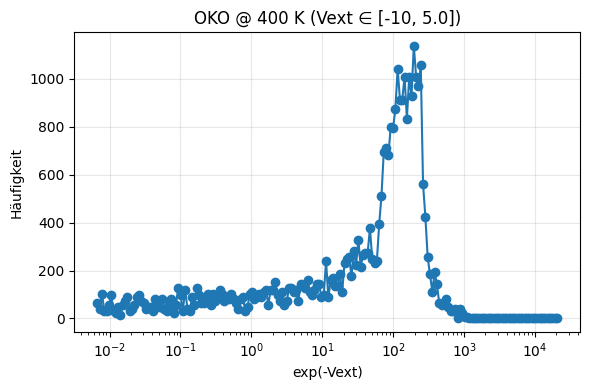

In [129]:
import matplotlib.pyplot as plt

target_struct = "OKO"
target_temp   = 400

row = df_all[(df_all["structure"] == target_struct) & (df_all["temperature"] == target_temp)]
if not row.empty:
    y = row[[c for c in row.columns if c.startswith("bin_")]].values.flatten()
    x = EDGES[:-1]  # linker Rand jeder Klasse
    plt.figure(figsize=(6,4))
    plt.plot(x, y, marker="o", lw=1.5)
    plt.xscale("log")
    plt.xlabel("exp(-Vext)")
    plt.ylabel("Häufigkeit")
    plt.title(f"{target_struct} @ {target_temp} K (Vext ∈ [{VEXT_MIN}, {VEXT_MAX}])")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Keine Zeile gefunden.")


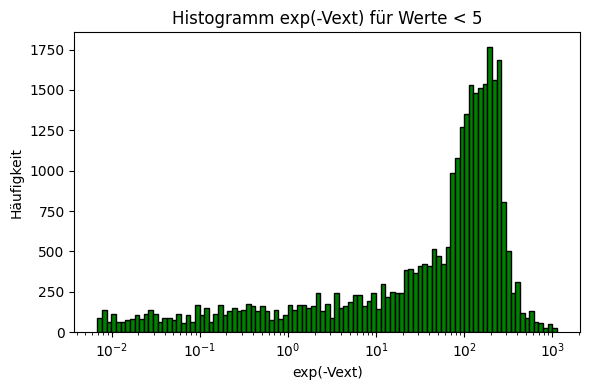

In [117]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# === Datei laden ===
with open("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP/Vext_400/Vext_OKO_400.pkl", "rb") as f:
    data = pickle.load(f)

# === Parameter ===
cutoff = 5
bins = 100

# === Daten vorverarbeiten ===
mask = data < cutoff
data_mask = data[mask]
data_exp = np.exp(-data_mask.flatten())

# === logarithmische Bins ===
bins_log = np.logspace(np.log10(data_exp.min()), np.log10(data_exp.max()), bins)

# === Histogramm ===
plt.figure(figsize=(6,4))
plt.hist(data_exp, bins=bins_log, color="green", edgecolor="black")

# === Plotformat ===
plt.xscale("log")
plt.xlabel("exp(-Vext)")
plt.ylabel("Häufigkeit")
plt.title(f"Histogramm exp(-Vext) für Werte < {cutoff}")
plt.tight_layout()
plt.show()


In [164]:
import os
import re
import pickle
import numpy as np
import pandas as pd

VEXT_MAX = 15.0       # cutoff oben
VEXT_MIN = -20.0     # cutoff unten
N_BINS   = 100

base_dir = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_32grid"
pattern  = re.compile(r"Vext_([A-Z]{3})_(\d+)\.pkl")

all_dfs = []

# temp ordner iterieren
for temp_folder in os.listdir(base_dir):
    temp_path = os.path.join(base_dir, temp_folder)
    if not (os.path.isdir(temp_path) and temp_folder.startswith("Vext_")):
        continue

    print(f"\nBearbeite Temperatur-Ordner: {temp_folder}")
    rows = []

    # alle pickle daten
    for filename in os.listdir(temp_path):
        if not filename.endswith(".pkl"):
            continue

        m = pattern.match(filename)
        if not m:
            print(f"Übersprungen (kein gültiger Name): {filename}")
            continue

        struct_name, temp = m.groups()
        file_path = os.path.join(temp_path, filename)

        # Entpickeln
        with open(file_path, "rb") as f:
            data = pickle.load(f)

        arr = np.asarray(data, dtype=np.float64).squeeze()
        arr = arr[np.isfinite(arr)]  # NaN/Inf entfernen

        # Mask und exp(-)
        if arr.size == 0:
            hist = np.zeros(N_BINS, dtype=int)
            edges = np.linspace(0, 1, N_BINS + 1)
        else:
            arr = np.clip(arr, VEXT_MIN, VEXT_MAX)
            arr_exp = np.exp(-arr)
            hist, edges = np.histogram(arr_exp, bins=N_BINS) # automatisch äquistante bins

        # struktur
        entry = {"structure": struct_name, "temperature": int(temp)}
        entry.update({f"bin_{i}": int(v) for i, v in enumerate(hist)})
        entry["x_min"] = float(edges[-1])
        entry["x_max"] = float(edges[0])
        rows.append(entry)

    # -
    if rows:
        df_temp = pd.DataFrame(rows)
        all_dfs.append(df_temp)
        print(f"{len(rows)} Strukturen verarbeitet")

# df_all zusammenführen
df_all = pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()
print(f"\n Gesamt-DataFrame mit {len(df_all)} Zeilen erstellt")

# csv
out_name = f"Vext_allTEMP_expV_autoBin_cut{VEXT_MAX}_{VEXT_MIN}_{N_BINS}Bins_32grid.csv"
out_path = os.path.join(base_dir, out_name)
df_all.to_csv(out_path, index=False)

print(f"Datei gespeichert unter:\n{out_path}")



 Gesamt-DataFrame mit 0 Zeilen erstellt
Datei gespeichert unter:
/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_32grid/Vext_allTEMP_expV_autoBin_cut15.0_-20.0_100Bins_32grid.csv


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_from_hist(hist, bin_edges, ax=None, xlog=False, title="", normalize=False, color="C0"):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    hist = np.asarray(hist, dtype=float)
    bin_edges = np.asarray(bin_edges, dtype=float)
    widths = bin_edges[1:] - bin_edges[:-1]

    if normalize and hist.sum() > 0:
        hist = hist / hist.sum()

    ax.bar(
        bin_edges[:-1],
        hist,
        width=widths,
        align='edge',
        edgecolor='black',
        color=color,
        linewidth=0.8,
    )

    if xlog:
        ax.set_xscale("log")

    ax.set_title(title, fontsize=12)
    ax.set_xlabel("exp(-Vext)", fontsize=11)
    ax.set_ylabel("relative Häufigkeit" if normalize else "Häufigkeit", fontsize=11)
    ax.grid(True, which="both", linestyle="--", alpha=0.4)
    ax.tick_params(axis="both", which="major", labelsize=10)

    return ax


📊 Plotting 50 Strukturen (Zeilen 0:50)


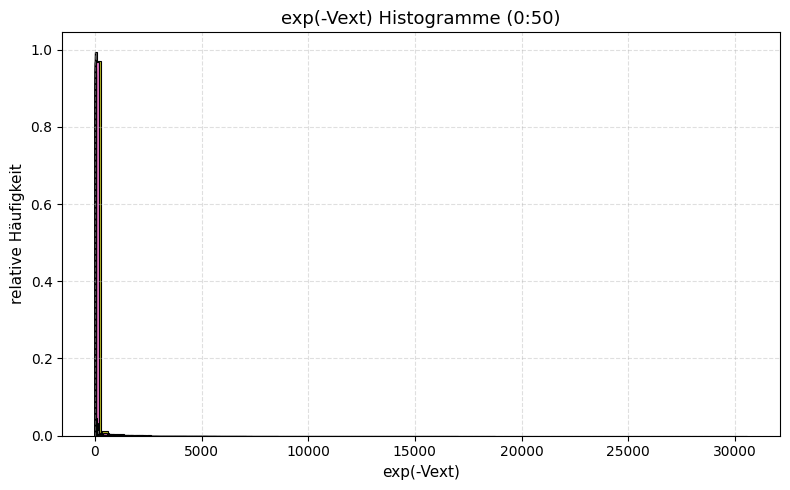

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- CSV-Datei einlesen ---
csv_path = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP/Vext_allTEMP_expV_autoBin_cut15.0_-20.0_100Bins.csv"
df = pd.read_csv(csv_path)

# --- Parameter ---
n_to_plot = 50     # Anzahl der zu plottenden Strukturen
offset = 0         # Startindex (entspricht df.iloc[offset:offset+n_to_plot])
subset = df.iloc[offset : offset + n_to_plot]

print(f"📊 Plotting {len(subset)} Strukturen (Zeilen {offset}:{offset+n_to_plot})")

# --- Plot vorbereiten ---
fig, ax = plt.subplots(figsize=(8, 5))
#ax.set_yscale("log")

for i, row in subset.iterrows():
    # Alle Spalten, die mit 'bin_' beginnen
    bins = [col for col in row.index if col.startswith("bin_")]
    hist = row[bins].values.astype(float)

    # Wertebereich rekonstruieren
    x_min, x_max = row["x_min"], row["x_max"]

    # --- Sicherheitschecks ---
    if not np.isfinite(x_min) or not np.isfinite(x_max) or x_min >= x_max:
        print(f"⚠️ Überspringe {row['structure_name']} – ungültige Kanten: x_min={x_min}, x_max={x_max}")
        continue
    if hist.sum() == 0:
        print(f"⚠️ Überspringe {row['structure_name']} – leeres Histogramm")
        continue

    n_bins = len(bins)
    edges = np.linspace(x_min, x_max, n_bins + 1)

    label = f"{row['structure_name']} ({row['temperature_kelvin']} K)"

    # Histogramm plotten (normiert für Vergleichbarkeit)
    plot_from_hist(hist, edges, ax=ax, normalize=True, color=None)
    ax.plot([], [], label=label)  # Legende ohne doppelte Balken

# --- Formatierung ---
ax.set_title(f"exp(-Vext) Histogramme ({offset}:{offset+n_to_plot})", fontsize=13)
#ax.legend(fontsize=8, loc="best")
ax.set_xlabel("exp(-Vext)")
ax.set_ylabel("relative Häufigkeit")
ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()
